# Машинное обучение

## Задача

Преобразование данных, полученных в [2_visualizing_data.ipynb](https://github.com/Aleks-Zink/Pet_Projects/blob/main/1_SpaceX/2_visualizing_data.ipynb) в цифровой формат и создание модели машинного обучения для "предсказания" результатов запуска ракеты ( успешный / провальный )

## Данные

DataFrame:
+ ./data/features.pkl

## Расчёты

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from hyperopt import fmin, tpe, hp, space_eval
from functools import partial
from catboost import CatBoostClassifier, Pool
from catboost import cv as cat_cv

### Features Engineering

In [2]:
# Признаки для машинного обучения
features = pd.read_pickle("./data/features.pkl")
features

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Class
0,1,8248.883228,LEO,CCSFS SLC 40,1.0,False,False,False,None,1.0,0.0,B0003,0
1,2,525.000000,LEO,CCSFS SLC 40,1.0,False,False,False,None,1.0,0.0,B0005,0
2,3,677.000000,ISS,CCSFS SLC 40,1.0,False,False,False,None,1.0,0.0,B0007,0
3,4,500.000000,PO,VAFB SLC 4E,1.0,False,False,False,None,1.0,0.0,B1003,0
4,5,3170.000000,GTO,CCSFS SLC 40,1.0,False,False,False,None,1.0,0.0,B1004,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,164,13260.000000,VLEO,KSC LC 39A,2.0,True,True,True,5e9e3033383ecb075134e7cd,5.0,1.0,B1069,1
164,165,13260.000000,VLEO,VAFB SLC 4E,7.0,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,6.0,B1063,1
165,166,13260.000000,VLEO,CCSFS SLC 40,6.0,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,5.0,B1067,1
166,167,13260.000000,VLEO,CCSFS SLC 40,4.0,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,0.0,B1072,1


In [3]:
# Применение One Hot кодирования номинальных переменных
pd.get_dummies(features[['Orbit', 'LaunchSite', 'LandingPad', 'Serial']],
               prefix=('Orbit', 'LaunchSite', 'LandingPad', 'Serial'))

,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,...,Serial_B1060,Serial_B1061,Serial_B1062,Serial_B1063,Serial_B1067,Serial_B1069,Serial_B1071,Serial_B1072,Serial_B1073,Serial_B1077
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
164,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
# Объединение числовых переменных и one hot переменных
features_one_hot = \
pd.concat((features[['FlightNumber', 'PayloadMass', 'Flights', 'Block', 'ReusedCount', 'GridFins', 'Reused', 'Legs', 'Class']],
           pd.get_dummies(features[['Orbit', 'LaunchSite', 'LandingPad', 'Serial']],
                          prefix=('Orbit', 'LaunchSite', 'LandingPad', 'Serial'))),
          axis=1)
features_one_hot

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,GridFins,Reused,Legs,Class,Orbit_ES-L1,...,Serial_B1060,Serial_B1061,Serial_B1062,Serial_B1063,Serial_B1067,Serial_B1069,Serial_B1071,Serial_B1072,Serial_B1073,Serial_B1077
0,1,8248.883228,1.0,1.0,0.0,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,525.000000,1.0,1.0,0.0,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,677.000000,1.0,1.0,0.0,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,500.000000,1.0,1.0,0.0,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,3170.000000,1.0,1.0,0.0,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,164,13260.000000,2.0,5.0,1.0,True,True,True,1,0,...,0,0,0,0,0,1,0,0,0,0
164,165,13260.000000,7.0,5.0,6.0,True,True,True,1,0,...,0,0,0,1,0,0,0,0,0,0
165,166,13260.000000,6.0,5.0,5.0,True,True,True,1,0,...,0,0,0,0,1,0,0,0,0,0
166,167,13260.000000,4.0,5.0,0.0,True,True,True,1,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Информация по каждому столбцу независимых переменных
features_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 92 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   FlightNumber                         168 non-null    int64  
 1   PayloadMass                          168 non-null    float64
 2   Flights                              168 non-null    float64
 3   Block                                168 non-null    float64
 4   ReusedCount                          168 non-null    float64
 5   GridFins                             168 non-null    object 
 6   Reused                               168 non-null    object 
 7   Legs                                 168 non-null    object 
 8   Class                                168 non-null    int32  
 9   Orbit_ES-L1                          168 non-null    uint8  
 10  Orbit_GEO                            168 non-null    uint8  
 11  Orbit_GTO                       

In [6]:
# Установление единого типа данных
features_one_hot = features_one_hot.astype('float64')

### Модели Машинного обучения

In [7]:
def metrics(y, y_predict):
    """
    Отрисовки Матрицы Ошибок и F1-score
    
    :param y: настоящие значения классов
    :param y_predict: предсказанныезначения классов
    
    :return: None
    """
    ConfusionMatrixDisplay.from_predictions(y_true=y,
                                            y_pred=y_predict,
                                            cmap='Blues',
                                            text_kw={'fontsize': 14})

    f1 = f1_score(y_true=y, y_pred=y_predict)

    print(f"F1_score:\t{f1}")

In [8]:
# Отбор независимых переменных
X = features_one_hot.drop('Class', axis=1)
X

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,GridFins,Reused,Legs,Orbit_ES-L1,Orbit_GEO,...,Serial_B1060,Serial_B1061,Serial_B1062,Serial_B1063,Serial_B1067,Serial_B1069,Serial_B1071,Serial_B1072,Serial_B1073,Serial_B1077
0,1.0,8248.883228,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,164.0,13260.000000,2.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
164,165.0,13260.000000,7.0,5.0,6.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
165,166.0,13260.000000,6.0,5.0,5.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
166,167.0,13260.000000,4.0,5.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
# Отбор зависимой (целевой) переменной
Y = features_one_hot['Class'].to_numpy()
Y

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# Стандартизация переменных (Z-score)
transform = preprocessing.StandardScaler()
X.iloc[:, :5] = transform.fit_transform(X.iloc[:, :5])
X

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,GridFins,Reused,Legs,Orbit_ES-L1,Orbit_GEO,...,Serial_B1060,Serial_B1061,Serial_B1062,Serial_B1063,Serial_B1067,Serial_B1069,Serial_B1071,Serial_B1072,Serial_B1073,Serial_B1077
0,-1.721771,0.000000,-0.845330,-2.314161,-1.178357,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.701151,-1.464136,-0.845330,-2.314161,-1.178357,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.680531,-1.435323,-0.845330,-2.314161,-1.178357,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.659911,-1.468875,-0.845330,-2.314161,-1.178357,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.639291,-0.962751,-0.845330,-2.314161,-1.178357,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.639291,0.949905,-0.535928,0.581772,-0.964110,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
164,1.659911,0.949905,1.011081,0.581772,0.107123,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
165,1.680531,0.949905,0.701679,0.581772,-0.107123,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
166,1.701151,0.949905,0.082875,0.581772,-1.178357,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
def CV(estimator, X, y, params_search, params_const, max_eavals=100, cv=5):
    """
    Подбор гиперпараметров с использованием Cross-Validation
    
    :param estimator: модель машинного обучения
    :param X: независимые переменные
    :param y: зависимая переменная
    :param params_search: описание гиперпараметров модели для поиска
    :param params_const: остальные параметры модели
    :param max_eavals: количество попыток найти наилучшие гиперпараметры
    :param cv: количество folds для Cross-Validation

    :return: модель машинного обучения с лучшими гиперпараметрами
    """
    def objective(params, model, X, y, cv=cv):
        """
        Вспомогательная функция нужная для получения 
        Крос-Валидированной оценки одного набора гиперпараметров

        :param params: один набор гиперпараметры взятые из params_search материнской функции
        :param model: модель машинного обучения с установленными params_const
        :param X: то же, что и в материнской функции
        :param y: то же, что и в материнской функции
        :param cv: то же, что и в материнской функции

        :return: средний результат F1-score по всем folds со знаком минус
        """
        
        # расчёт F1-score по каждому fold
        if type(model) == CatBoostClassifier:

            cv_data = cat_cv(
                pool=Pool(data=X, label=y),
                params={'loss_function': 'Logloss',
                        'eval_metric': 'TotalF1',
                        **params},
                fold_count=cv,
                logging_level='Silent',
                seed=0)
            
            results = np.max(cv_data['test-TotalF1-mean'])

        else:

            # устанавливаем один набор гиперпараметров из params_search
            model.set_params(**params)

            cv_data = cross_val_score(
                estimator=model,
                X=X,
                y=y,
                scoring='f1',
                cv=cv,
                n_jobs=-1)
            
            results = cv_data.mean()

        return -results

    # поиск наилучшего набора гиперпараметров (выводит индексы, а не значения)
    best_params = fmin(fn=partial(objective,
                                  model=estimator(**params_const),
                                  X=X,
                                  y=y),
                       space=params_search,
                       algo=tpe.suggest,
                       max_evals=max_eavals,
                       rstate=np.random.default_rng(seed=0))

    # сопоставление значений гиперпараметров с их индексами
    best_params = space_eval(params_search, best_params)

    # создаём модель машинного обучения с наилучшими гиперпараметрами
    best_estimator = estimator(**{**params_const, **best_params})

    # обучение данной модели
    if estimator == CatBoostClassifier:
        X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size=0.2, random_state=0)
        best_estimator.fit(X=X_train, y=y_train, eval_set=Pool(data=X_val, label=y_val), verbose=False)
    else:
        best_estimator.fit(X=X, y=y)
        
    
    print(f"\nЛучшие гиперпараметры: {best_params}")

    return best_estimator

In [12]:
# логистическая регрессия с L1 регуляризацией для выделения наиболее важных переменных
log_reg_sep = CV(estimator=LogisticRegression,
                 X=X,
                 y=Y,
                 params_search={'C': hp.uniform('C', low=1e-4, high=1e6),
                                'max_iter': hp.choice('max_iter', range(1_000, 10_000, 200))},
                 params_const={'penalty': 'l1',
                               'random_state': 0,
                               'solver': 'liblinear'})

100%|██████████| 100/100 [00:07<00:00, 12.56trial/s, best loss: -0.8705372448663178]

Лучшие гиперпараметры: {'C': 10406.801586167367, 'max_iter': 6200}


In [13]:
# Важные переменные
temp_v = np.sort(np.abs(log_reg_sep.coef_))[0][::-1]
temp_i = np.argsort(np.abs(log_reg_sep.coef_))[0][::-1]

important_columns = X.columns[temp_i[temp_v!=0]]
important_columns

Index(['Serial_B1050', 'Serial_B1017', 'LandingPad_5e9e3033383ecb075134e7cd',
       'Serial_B1049', 'Serial_B1028', 'Serial_B1006',
       'LandingPad_5e9e3032383ecb267a34e7c7', 'Serial_B1044',
       'LandingPad_5e9e3033383ecbb9e534e7cc', 'Serial_B1036', 'Serial_B1020',
       'Flights', 'Serial_B1051', 'Serial_B1061', 'ReusedCount',
       'Serial_B1060', 'Serial_B1007', 'Serial_B1021', 'Serial_B1041',
       'Orbit_ISS', 'Serial_B1056', 'Serial_B1018', 'LaunchSite_KSC LC 39A',
       'Serial_B1063', 'Serial_B1039', 'Serial_B1031', 'Legs', 'Serial_B1054',
       'Serial_B1058', 'LandingPad_5e9e3032383ecb6bb234e7ca', 'Serial_B1029',
       'GridFins', 'Orbit_PO', 'Serial_B1040', 'Orbit_MEO', 'Serial_B1059',
       'Serial_B1047', 'PayloadMass', 'Block',
       'LandingPad_5e9e3032383ecb761634e7cb', 'Serial_B1032',
       'LaunchSite_VAFB SLC 4E', 'Orbit_VLEO', 'Serial_B1048', 'Serial_B1071',
       'Orbit_ES-L1', 'Serial_B0005', 'Reused', 'Orbit_GTO', 'Serial_B1013',
       'FlightNu

In [14]:
# Уменьшение колличества независимых переменных, ограничиваясь только перечнем important_columns
X = X[important_columns]
X

,Serial_B1050,Serial_B1017,LandingPad_5e9e3033383ecb075134e7cd,Serial_B1049,Serial_B1028,Serial_B1006,LandingPad_5e9e3032383ecb267a34e7c7,Serial_B1044,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B1036,...,Serial_B1071,Orbit_ES-L1,Serial_B0005,Reused,Orbit_GTO,Serial_B1013,FlightNumber,Serial_B1005,Serial_B1004,LaunchSite_CCSFS SLC 40
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.721771,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-1.701151,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.680531,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.659911,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,-1.639291,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.639291,0.0,0.0,0.0
164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.659911,0.0,0.0,0.0
165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.680531,0.0,0.0,1.0
166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.701151,0.0,0.0,1.0


In [15]:
# Разделение данных на выборку для обучения и для теста
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=0)
print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборкм: {X_test.shape[0]}")

Размер тренировочной выборки: 134
Размер тестовой выборкм: 34


Две нулевые гипотезы, с которыми будем сравнивать полученные в дальнейшем модели МО

№1 Случайно предсказывать удачу с вероятностью 81,55%

In [16]:
percent_of_success = features["Class"].mean()
percent_of_success

0.8154761904761905

In [17]:
np.random.seed(1)
y_hat_rand = np.where(np.random.rand(*Y_test.shape)<percent_of_success, 1, 0)
y_hat_rand

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1])

F1_score:	0.7636363636363638


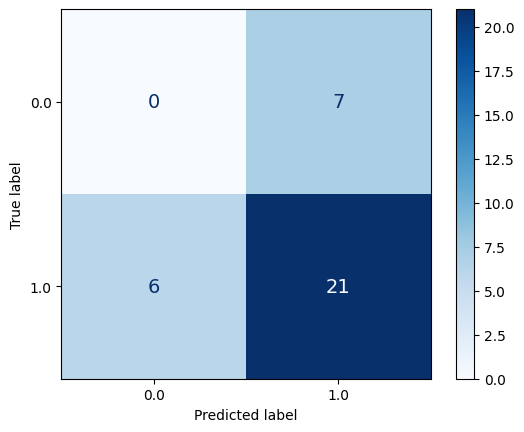

In [18]:
metrics(Y_test, y_hat_rand)

№2 Говорить что каждый запуск удачный

In [19]:
y_hat_ones = np.ones_like(Y_test)
y_hat_ones

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

F1_score:	0.8852459016393442


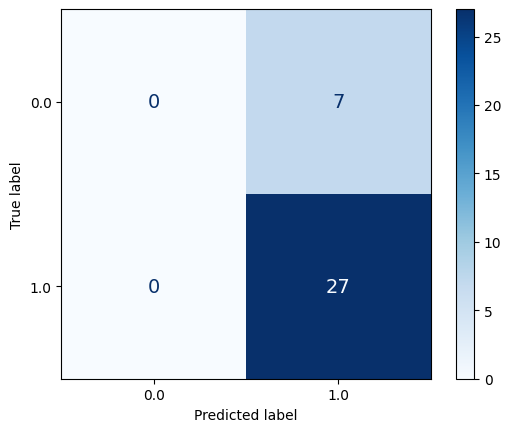

In [20]:
f1_ones = metrics(Y_test, y_hat_ones)

Создадим и обучим 6 модели Машинного Обучения для решения задачи классификации

In [21]:
# Поиск наилучшей модели Логистической модели
logreg_cv = CV(estimator=LogisticRegression,
               X=X_train,
               y=Y_train,
               params_search={'C': hp.uniform('C', low=1e-4, high=1e6),
                              'max_iter': hp.choice('max_iter', range(1_000, 10_000, 200))},
               params_const={'penalty': 'l2',
                             'random_state': 0,
                             'n_jobs': -1})

100%|██████████| 100/100 [00:03<00:00, 26.29trial/s, best loss: -0.9409348139782923]

Лучшие гиперпараметры: {'C': 926536.6322254188, 'max_iter': 1800}


In [22]:
# Поиск наилучшей мождели Метода Опорных Векторов
svm_cv = CV(estimator=SVC,
            X=X_train,
            y=Y_train,
            params_search={'C': hp.uniform('C', low=1e-3, high=1e3),
                           'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
                           'degree': hp.randint('degree', 10),
                           'tol': hp.uniform('tol', low=1e-5, high=1e-1)},
            params_const={'random_state': 0})

100%|██████████| 100/100 [00:02<00:00, 42.00trial/s, best loss: -0.950877429502303]

Лучшие гиперпараметры: {'C': 812.0203840934948, 'degree': 6, 'kernel': 'rbf', 'tol': 0.09983515411939413}


In [23]:
# Поиск наилучшего Решающего дерева
tree_cv = CV(estimator=DecisionTreeClassifier,
             X=X_train,
             y=Y_train,
             params_search={'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
                            'splitter': hp.choice('splitter', ['best', 'random']),
                            'max_depth': hp.choice('max_depth', [None, *range(1, 40)]),
                            'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
                            'min_samples_split': hp.choice('min_samples_split', range(2,20)),
                            'min_samples_leaf': hp.choice('min_samples_leaf', range(1,20))},
             params_const={'random_state': 0})

100%|██████████| 100/100 [00:02<00:00, 36.04trial/s, best loss: -0.9559121277530158]

Лучшие гиперпараметры: {'criterion': 'entropy', 'max_depth': 28, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 16, 'splitter': 'random'}


In [24]:
# Поиск наилучшего Случайного леса 
forest_cv = CV(estimator=RandomForestClassifier,
               X=X_train,
               y=Y_train,
               params_search={'n_estimators': hp.choice('n_estimators', range(50, 200, 10)),
                              'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
                              'max_depth': hp.choice('max_depth', [None, *range(1, 40)]),
                              'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
                              'min_samples_split': hp.choice('min_samples_split', range(2,20)),
                              'min_samples_leaf': hp.choice('min_samples_leaf', range(1,20))},
               params_const={'bootstrap': True,
                             'n_jobs': -1,
                             'random_state': 0})

100%|██████████| 100/100 [00:34<00:00,  2.89trial/s, best loss: -0.9495670067466208]

Лучшие гиперпараметры: {'criterion': 'gini', 'max_depth': 19, 'max_features': None, 'min_samples_leaf': 12, 'min_samples_split': 7, 'n_estimators': 190}


In [25]:
# Поиск наилучшего Градиентного бустинга
gradboost_cv = CV(estimator=CatBoostClassifier,
                  X=X_train,
                  y=Y_train,
                  params_search={'iterations': hp.choice('iterations', range(1, 200, 20)),
                                 'depth': hp.choice('depth', range(1, 16)),
                                 'learning_rate': hp.uniform('learning_rate', low=1e-4, high=1)},
                  params_const={'loss_function': 'Logloss',
                                'eval_metric': 'TotalF1',
                                'use_best_model': True,
                                'random_seed': 0})

100%|██████████| 100/100 [22:48<00:00, 13.69s/trial, best loss: -0.939213772408919]  

Лучшие гиперпараметры: {'depth': 9, 'iterations': 101, 'learning_rate': 0.46340036413533636}


In [26]:
# Поиск наилучшей модели K ближайших соседей
knn_cv = CV(estimator=KNeighborsClassifier,
            X=X_train,
            y=Y_train,
            params_search={'n_neighbors': hp.choice('n_neighbors', range(2, 21, 3)),
                           'weights': hp.choice('weights', ['uniform', 'distance']),
                           'p': hp.choice('p', [1, 2])},
            params_const={'n_jobs': -1})

100%|██████████| 100/100 [00:06<00:00, 14.40trial/s, best loss: -0.9474272792681674]

Лучшие гиперпараметры: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}


In [27]:
print(f'Успех c p= {percent_of_success:.2%}:\t{f1_score(y_pred=y_hat_rand, y_true=Y_test):.4f}')
print(f'Успех c p= 100%:\t{f1_score(y_pred=y_hat_ones, y_true=Y_test):.4f}')
print('='*30)
print(f'Логистическая регрессия:{f1_score(y_true=Y_test, y_pred=logreg_cv.predict(X_test)):.4f}')
print(f'Метод опорных векторов:\t{f1_score(y_true=Y_test, y_pred=svm_cv.predict(X_test)):.4f}')
print(f'Решающее дерево:\t{f1_score(y_true=Y_test, y_pred=tree_cv.predict(X_test)):.4f}')
print(f'Случайный лес:\t\t{f1_score(y_true=Y_test, y_pred=forest_cv.predict(X_test)):.4f}')
print(f'Градиентный бустинг:\t{f1_score(y_true=Y_test, y_pred=gradboost_cv.predict(X_test)):.4f}')
print(f'K ближайших соседей:\t{f1_score(y_true=Y_test, y_pred=knn_cv.predict(X_test)):.4f}')

Успех c p= 81.55%:	0.7636
Успех c p= 100%:	0.8852
Логистическая регрессия:0.9286
Метод опорных векторов:	0.9286
Решающее дерево:	0.9286
Случайный лес:		0.9091
Градиентный бустинг:	0.9286
K ближайших соседей:	0.9286


Все Модели МО превосходят нулевую гипотезу №1 и №2  
  
Почти все модели имеют одинаковое значение метрики, значит, нет большой разницы, какую именно выберем в итоге.  
В качестве итоговой модели возьмём модель Логистической Регрессии из-за наибольшей простоты интерпретации самой модели.

F1_score:	0.9285714285714286


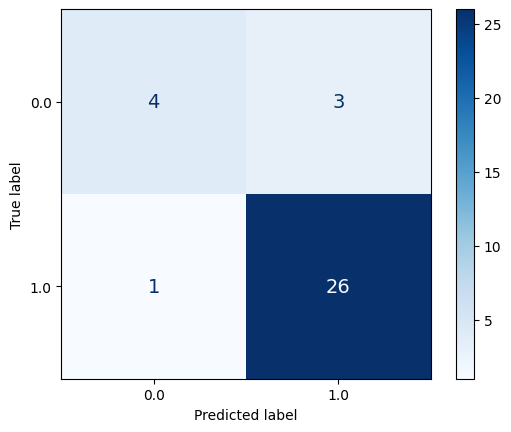

In [28]:
# F1-score Логистической Регресси и её Матрица Ошибок на тестовой выборке
metrics(Y_test, logreg_cv.predict(X_test))

In [29]:
# От каких 3 переменных в наибольшей степени зависит "предсказание" неудачного запуска
for i in X_train.columns[np.argsort(logreg_cv.coef_[0])[:3]]:
    print(i)

Serial_B1050
Serial_B1017
Serial_B1028


То есть, согласно модели, ракеты серии B1050, ...17 и ...28 с большей вероятностью разобъются.

In [30]:
# От каких 3 переменных в наибольшей степени зависит "предсказание" удачного запуска
for i in X_train.columns[np.argsort(logreg_cv.coef_[0])[:-4:-1]]:
    print(i)

ReusedCount
Serial_B1006
Serial_B1036


А ракета серии B1006 или ...36 с большей вероятностью удачно приземлятся.  
Помимо этого, число повторных использований повысит вероятность удачного запуска.

## Результаты

Была разработана модель машинного обучения, основанная на Логистической Регрессии, способная "пердсказать" результат запуска ракеты